# Using Market Dynamics to Make the Playoffs in Best Ball Mania

## Tim Bryan

[@timbryan000](https://www.twitter.com/timbryan000)

>"I believe the market accurately reflects not the truth, which is what the efficient market hypothesis says, but it accurately and efficiently reflects everybody's opinion as to what's true." - Howard Marks

One advantage in modeling prices of stocks or sport gambling is the existence of a market. By nature, there is wisdom embedded in these markets through competition, and that wisdom can be extracted. There's the traditional approach I'll call "fundamental" modeling -- actually look at things like player projections or strength of schedule. The approach that I offer is "technical" modeling. We're going to look at how __market dynamics__ can help us advance to the playoffs in Best Ball Mania. 

_Does "buying low" on a player (i.e. drafting on an ADP downtrend) help playoffs odds?_

_Is there real value in value drafting based on the lowest ADP available?_ 

_Does market confidence indicate a bargain?_ 

Let's find out.

## Dependencies and Housekeeping
We only need these standard Python libraries for our data modeling. We won't be connecting to play-by-play data or any other outside sources to help us here. Just raw market dynamics.

In [1]:
# Basic Dependencies
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data Loading and Preparation

Let's create a function for loading our data - the structure of 2021 and 2022 are a little different so we'll handle for that and then combine the DataFrames.

In [2]:
def load_year_data(year):
    """
    Load the Best Ball data into a DataFrame, handles 2021 and 2022 differences in file structure
    """
    df = []
    # Determine the subdirectory based on the year
    subdir = '' if year == 2021 else '/fast'
    
    # Load regular season data
    for file in os.listdir(f'../data/{year}/regular_season{subdir}'):
        df.append(pd.read_csv(f'../data/{year}/regular_season{subdir}/{file}'))
    df = pd.concat(df, ignore_index=True)

    # Determine how to load post season data based on the year
    post_season_loaders = {'qf': [], 'sf': None, 'f': None}
    if year == 2021:
        post_season_loaders['qf'].append(pd.read_csv(f'../data/{year}/post_season/quarterfinals.csv'))
        post_season_loaders['sf'] = pd.read_csv(f'../data/{year}/post_season/semifinals.csv')
        post_season_loaders['f'] = pd.read_csv(f'../data/{year}/post_season/finals.csv')
    else:
        for file in os.listdir(f'../data/{year}/post_season/quarterfinals/'):
            post_season_loaders['qf'].append(pd.read_csv(f'../data/{year}/post_season/quarterfinals/{file}'))
        post_season_loaders['sf'] = pd.read_csv(f'../data/{year}/post_season/semifinals/part_00.csv')
        post_season_loaders['f'] = pd.read_csv(f'../data/{year}/post_season/finals/part_00.csv')

    post_season_loaders['qf'] = pd.concat(post_season_loaders['qf'], ignore_index=True)
    
    # Convert playoff dataframes to dictionaries and map onto df
    for k, playoffs_df in post_season_loaders.items():
        playoffs_dict = dict(zip(playoffs_df['tournament_entry_id'], [1]*len(playoffs_df)))
        df[k] = df['tournament_entry_id'].map(playoffs_dict).fillna(0).astype(int)

    # Add a column for the year
    df['year'] = year
    
    return df

In [3]:
df21 = load_year_data(2021)
df22 = load_year_data(2022)

In [4]:
# Combine the dataframes
df = pd.concat([df21, df22], ignore_index=True)

In [5]:
# Drop columns that are not needed
df = df.drop(columns=['draft_entry_id', 'tournament_round_draft_entry_id'])

In [6]:
df.head()

,draft_id,draft_time,clock,tournament_entry_id,tournament_round_number,player_name,position_name,bye_week,projection_adp,pick_order,overall_pick_number,team_pick_number,pick_points,roster_points,playoff_team,qf,sf,f,year
0,64c5c57f-dfe6-49b7-a0c2-180a8e8e2ad9,2021-07-20 05:54:15.422561+00:00,30,e762e1de-c639-431b-bbb6-1e30ee9e291f,1,Cam Akers,RB,11,12.14,10,15,2,0.00,1675.10,0,0,0,0,2021
1,64c5c57f-dfe6-49b7-a0c2-180a8e8e2ad9,2021-07-20 05:54:15.422561+00:00,30,5e1f4e64-41fa-47ab-8c4b-5562fd1e9eb0,1,Brandin Cooks,WR,10,91.48,5,92,8,103.60,1554.92,0,0,0,0,2021
2,64c5c57f-dfe6-49b7-a0c2-180a8e8e2ad9,2021-07-20 05:54:15.422561+00:00,30,f33b8689-4157-409d-950a-0b12244954e2,1,Noah Fant,TE,11,100.64,6,102,9,72.30,1656.58,0,0,0,0,2021
3,64c5c57f-dfe6-49b7-a0c2-180a8e8e2ad9,2021-07-20 05:54:15.422561+00:00,30,aeba7ded-dfeb-4b96-bc59-501c4ca29202,1,Matt Ryan,QB,6,138.23,8,152,13,97.56,1732.12,1,1,0,0,2021
4,64c5c57f-dfe6-49b7-a0c2-180a8e8e2ad9,2021-07-20 05:54:15.422561+00:00,30,072a49a9-bc24-4176-b09b-e053fc9f05eb,1,A.J. Brown,WR,13,23.25,2,23,2,103.50,1614.82,0,0,0,0,2021


## Market Dynamics

### ADP Trend

Next, let's add a column for ADP trend. We'll compare player ADP at the earliest draft date to ADP at the time of the respective draft. Then we'll split it by positon so that we can later sum by draft entry. This will help us understand if there's value, for example, in drafting WRs that are trending up or another correlations

In [7]:
# Convert the 'draft_time' column to datetime
df['draft_time'] = pd.to_datetime(df['draft_time'], utc=True)

# Extract only the date from the datetime
df['draft_time'] = df['draft_time'].dt.date

# Find the earliest ADP for each player
earliest_adp = df.sort_values('draft_time').groupby('player_name')['projection_adp'].first()

# Subtract the earliest ADP from the current ADP
df['adp_trend'] = df['player_name'].map(earliest_adp) - df['projection_adp']

In [8]:
# Define the positions
positions = ['QB', 'RB', 'TE', 'WR']

# Create a column for each position adp trend
for pos in positions:
    df['adp_trend_' + pos] = np.where(df['position_name'] == pos, df['adp_trend'], 0)

In [9]:
# Get a look at the new adp trend columns
df.head()

,draft_id,draft_time,clock,tournament_entry_id,tournament_round_number,player_name,position_name,bye_week,projection_adp,pick_order,...,playoff_team,qf,sf,f,year,adp_trend,adp_trend_QB,adp_trend_RB,adp_trend_TE,adp_trend_WR
0,64c5c57f-dfe6-49b7-a0c2-180a8e8e2ad9,2021-07-20,30,e762e1de-c639-431b-bbb6-1e30ee9e291f,1,Cam Akers,RB,11,12.14,10,...,0,0,0,0,2021,-1.09,0.00,-1.09,0.00,0.00
1,64c5c57f-dfe6-49b7-a0c2-180a8e8e2ad9,2021-07-20,30,5e1f4e64-41fa-47ab-8c4b-5562fd1e9eb0,1,Brandin Cooks,WR,10,91.48,5,...,0,0,0,0,2021,0.87,0.00,0.00,0.00,0.87
2,64c5c57f-dfe6-49b7-a0c2-180a8e8e2ad9,2021-07-20,30,f33b8689-4157-409d-950a-0b12244954e2,1,Noah Fant,TE,11,100.64,6,...,0,0,0,0,2021,-9.61,0.00,0.00,-9.61,0.00
3,64c5c57f-dfe6-49b7-a0c2-180a8e8e2ad9,2021-07-20,30,aeba7ded-dfeb-4b96-bc59-501c4ca29202,1,Matt Ryan,QB,6,138.23,8,...,1,1,0,0,2021,-26.31,-26.31,0.00,0.00,0.00
4,64c5c57f-dfe6-49b7-a0c2-180a8e8e2ad9,2021-07-20,30,072a49a9-bc24-4176-b09b-e053fc9f05eb,1,A.J. Brown,WR,13,23.25,2,...,0,0,0,0,2021,-5.25,0.00,0.00,0.00,-5.25


Plotting this data in a regression plot is very computationally demanding since there's so many data points. Instead, let's print correlation coefficients to pick points by position.

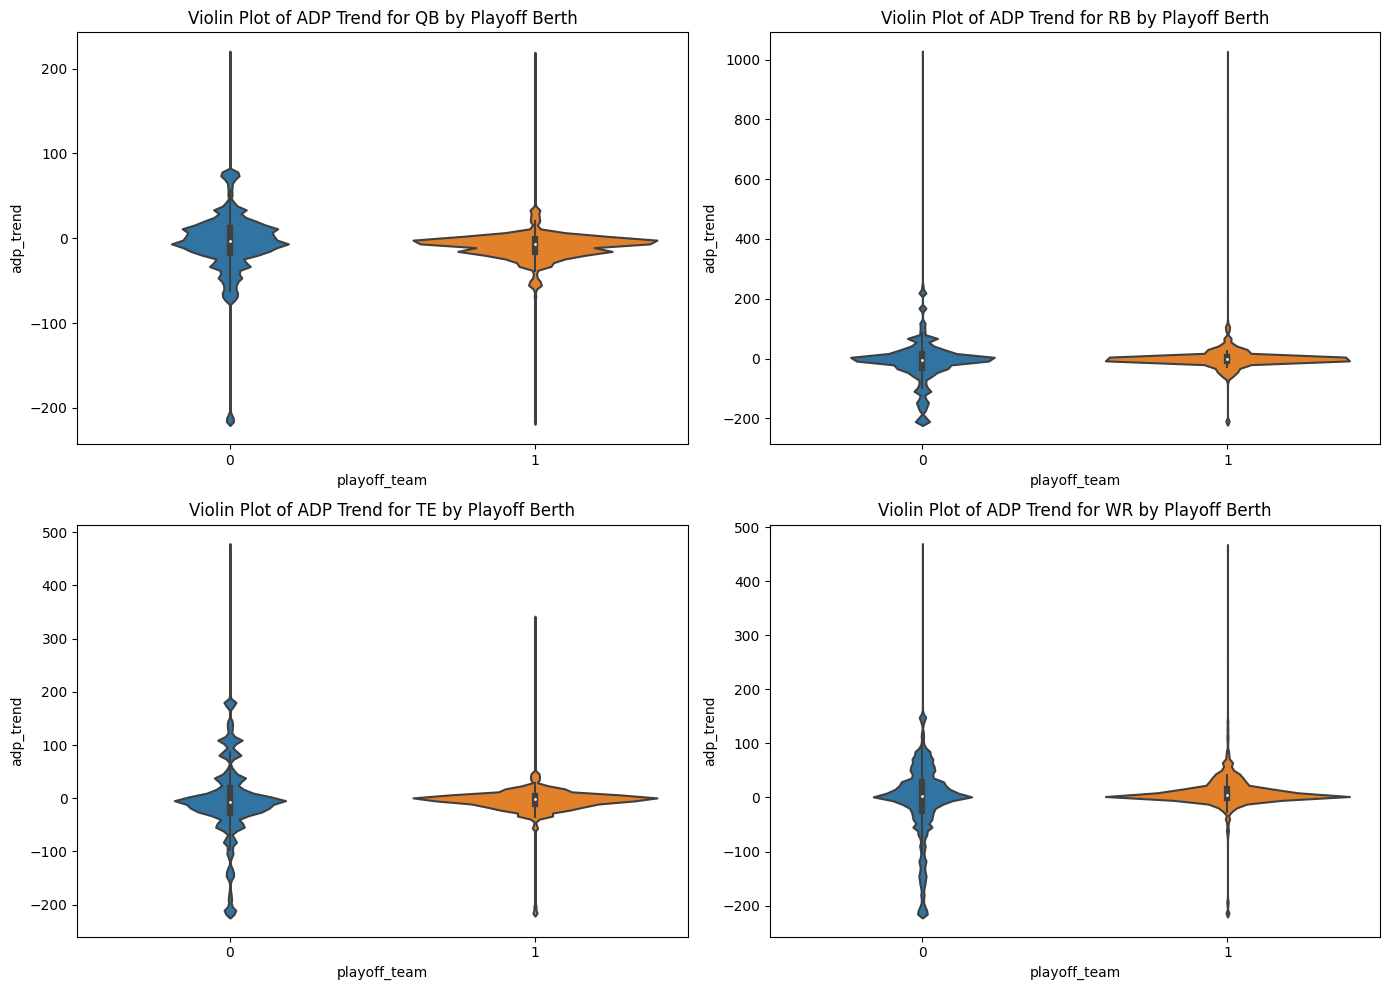

In [14]:
# Create a new figure with 4 subplots (one for each position)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

# Flatten the axes array to iterate over it
axes = axes.flatten()

# For each position
for i, pos in enumerate(positions):
    # Filter the dataframe
    df_pos = df[df['position_name'] == pos]

    # Generate a violin plot on the appropriate subplot
    sns.violinplot(x='playoff_team', y='adp_trend', data=df_pos, ax=axes[i])

    # Set the title of the subplot
    axes[i].set_title(f'Violin Plot of ADP Trend for {pos} by Playoff Berth')

# Improve layout
plt.tight_layout()

# Show the figure
plt.show()

These are all relatively weak positive correlations. We can interpret this as when ADP trend is increasing (aka player stock is __decreasing__) then the pick points are also increasing. In other words, the market can tend to overly discount certain positions - especially TEs and WRs. It's import we keep in mind these linear correlations are pretty weak; later on, we'll use machine learning techniques to see if there is potentially any non-linear relationships between ADP trend and playoff odds.

### Draft Delta
ADP reflects the markets valuation of a player. Some entries in this dataset closely follow market values, where others may have their own propritary valuation method. Let's see how the delta between ADP and actual draft position relates to playoff berth.

In [ ]:
# Create a column for delta from ADP
df['market_delta'] = df['projection_adp'] - df['overall_pick_number']

In [ ]:
# Create a column for delta from ADP by position
for pos in positions:
    df['market_delta_' + pos] = np.where(df['position_name'] == pos, df['market_delta'], 0)

In [ ]:
df.head()

,draft_id,draft_time,clock,tournament_entry_id,tournament_round_number,player_name,position_name,bye_week,projection_adp,pick_order,...,adp_trend,adp_trend_QB,adp_trend_RB,adp_trend_TE,adp_trend_WR,market_delta,market_delta_QB,market_delta_RB,market_delta_TE,market_delta_WR
0,64c5c57f-dfe6-49b7-a0c2-180a8e8e2ad9,2021-07-20,30,e762e1de-c639-431b-bbb6-1e30ee9e291f,1,Cam Akers,RB,11,12.14,10,...,-1.09,0.00,-1.09,0.00,0.00,-2.86,0.00,-2.86,0.00,0.00
1,64c5c57f-dfe6-49b7-a0c2-180a8e8e2ad9,2021-07-20,30,5e1f4e64-41fa-47ab-8c4b-5562fd1e9eb0,1,Brandin Cooks,WR,10,91.48,5,...,0.87,0.00,0.00,0.00,0.87,-0.52,0.00,0.00,0.00,-0.52
2,64c5c57f-dfe6-49b7-a0c2-180a8e8e2ad9,2021-07-20,30,f33b8689-4157-409d-950a-0b12244954e2,1,Noah Fant,TE,11,100.64,6,...,-9.61,0.00,0.00,-9.61,0.00,-1.36,0.00,0.00,-1.36,0.00
3,64c5c57f-dfe6-49b7-a0c2-180a8e8e2ad9,2021-07-20,30,aeba7ded-dfeb-4b96-bc59-501c4ca29202,1,Matt Ryan,QB,6,138.23,8,...,-26.31,-26.31,0.00,0.00,0.00,-13.77,-13.77,0.00,0.00,0.00
4,64c5c57f-dfe6-49b7-a0c2-180a8e8e2ad9,2021-07-20,30,072a49a9-bc24-4176-b09b-e053fc9f05eb,1,A.J. Brown,WR,13,23.25,2,...,-5.25,0.00,0.00,0.00,-5.25,0.25,0.00,0.00,0.00,0.25


### Market Confidence

## Modeling Preparation (think of a better title dude)

maybe do something with bye week, see below perhaps dont drop it?

In [ ]:
# Drop the columns we don't need
df = df.drop(columns=['draft_id', 'draft_time', 'tournament_round_number', 
                      'player_name', 'position_name', 'bye_week', 
                      'projection_adp', 'overall_pick_number', 'pick_points',
                      'roster_points', 'qf', 'sf', 'f', 'year'])

In [ ]:
# Group by tournament entry id - mean for the trend columns and delta columns, last for pick order and clock
model_df = df.groupby('tournament_entry_id').agg({'adp_trend': 'mean',
                                                    'adp_trend_QB': 'mean',
                                                    'adp_trend_RB': 'mean',
                                                    'adp_trend_TE': 'mean',
                                                    'adp_trend_WR': 'mean',
                                                    'market_delta': 'mean',
                                                    'market_delta_QB': 'mean',
                                                    'market_delta_RB': 'mean',
                                                    'market_delta_TE': 'mean',
                                                    'market_delta_WR': 'mean',
                                                    'pick_order': 'last',
                                                    'clock': 'last',
                                                    'playoff_team': 'last'})

In [ ]:
model_df.head()

,adp_trend,adp_trend_QB,adp_trend_RB,adp_trend_TE,adp_trend_WR,market_delta,market_delta_QB,market_delta_RB,market_delta_TE,market_delta_WR,pick_order,clock,playoff_team
tournament_entry_id,,,,,,,,,,,,,
0000146a-e245-49c3-8a4e-8e739cfe1e46,4.963333,-0.298333,12.082222,1.321111,-8.141667,6.303889,0.377778,5.035000,0.021111,0.870000,6,30,0
0000225d-54fa-4334-aa1e-41e7adaa2542,-19.901111,-1.048889,-11.261111,-3.593333,-3.997778,-1.052778,0.006667,-0.147222,-0.446111,-0.466111,2,30,0
00004939-5e99-4dfb-b597-d6463eacf6aa,-15.756111,-4.037778,-15.714444,4.042222,-0.046111,2.253333,4.343889,0.462222,-0.539444,-2.013333,2,30,0
0000766d-7308-495e-ad86-6ddb69dbc3ab,-7.181111,-6.191667,-7.062222,-5.927222,12.000000,-2.895556,0.023333,-0.858333,-0.015556,-2.045000,9,30,0
00007ef0-3100-479d-be3c-e7263edb4b5b,-4.123889,-5.725000,3.697222,6.513889,-8.610000,-2.531667,1.474444,-2.068333,-0.075000,-1.862778,10,30,0


In [ ]:
from pycaret.classification import *

# Initialize the setup
clf1 = setup(data=model_df, target='playoff_team', session_id=123, log_experiment=True, experiment_name='nfl', fix_imbalance=True)

,Description,Value
0,session_id,123
1,Target,playoff_team
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(493775, 13)"
5,Missing Values,False
6,Numeric Features,10
7,Categorical Features,2
8,Ordinal Features,False
9,High Cardinality Features,False


In [ ]:
# Compare models
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dummy,Dummy Classifier,0.9478,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0140
et,Extra Trees Classifier,0.9448,0.8474,0.0198,0.2087,0.0362,0.0273,0.0496,48.9950
rf,Random Forest Classifier,0.9398,0.8475,0.0514,0.2018,0.0820,0.0621,0.0781,69.2890
dt,Decision Tree Classifier,0.8945,0.5742,0.2165,0.1489,0.1764,0.1221,0.1246,5.3140
lightgbm,Light Gradient Boosting Machine,0.8922,0.8577,0.3219,0.1886,0.2378,0.1841,0.1917,3.5310
gbc,Gradient Boosting Classifier,0.8393,0.8538,0.5621,0.1757,0.2677,0.2043,0.2485,74.8410
ada,Ada Boost Classifier,0.8116,0.8405,0.6383,0.1644,0.2615,0.1946,0.2543,19.2500
knn,K Neighbors Classifier,0.7910,0.7673,0.5945,0.1419,0.2291,0.1581,0.2133,14.2280
nb,Naive Bayes,0.7562,0.8347,0.7943,0.1512,0.2540,0.1822,0.2735,1.1390
lr,Logistic Regression,0.6298,0.7409,0.7608,0.1000,0.1768,0.0930,0.1743,7.0310


DummyClassifier(constant=None, random_state=123, strategy='prior')